In [ ]:
%load_ext autoreload
%autoreload 2

from data_reading import read_images, load_reference_poses, read_imu
from visualization import visualize_trajectory
import pyGMs

imgs = read_images()
imu = read_imu()
gt_poses = load_reference_poses()

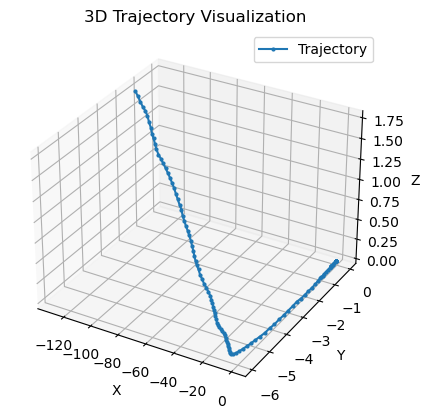

In [12]:
visualize_trajectory(gt_poses[:1500:10])

In [ ]:
import gtsam

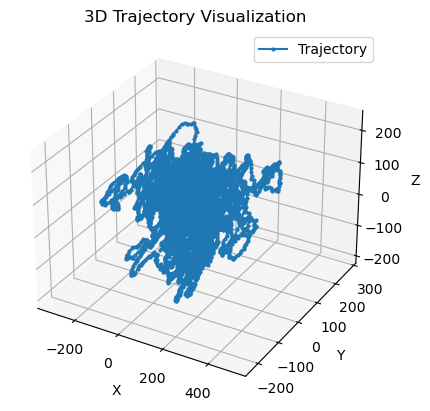

In [4]:
from scipy.spatial.transform import Rotation
# visualize integrating IMU
current_pose = gt_poses[0]
dead_reckoning_poses = [current_pose]
accel_0 = imu[0][4:7]
gyro_0 = imu[0][1:4]
for i in range(36,50000):
    imu_data = imu[i]
    timestamp = imu_data[0]
    gyro = imu_data[1:4] - gyro_0
    accel = imu_data[4:7] - accel_0
    dt = timestamp - current_pose[0]
    d_pos = 0.5 * current_pose[2].apply(accel) * dt**2
    curr_euler = current_pose[2].as_euler('XYZ', degrees=False)
    d_rot = gyro * dt
    new_pose = [
        current_pose[0]+dt,
        d_pos + current_pose[1],
        Rotation.from_euler('XYZ', curr_euler + d_rot, degrees=False)
    ]
    dead_reckoning_poses.append(new_pose)
    
visualize_trajectory(dead_reckoning_poses)
    

Loaded LightGlue model


/home/forge/.local/lib/python3.10/site-packages/kornia/feature/integrated.py:516: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw1_ = torch.tensor(hw1, device=dev)
/home/forge/.local/lib/python3.10/site-packages/kornia/feature/integrated.py:520: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw2_ = torch.tensor(hw2, device=dev)


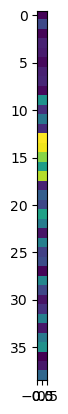

In [ ]:
from kornia.feature import DISK, LightGlueMatcher, laf_from_center_scale_ori
import torch

disk = DISK.from_pretrained('depth')
img1 = torch.tensor(imgs[0][1], dtype=torch.float32).permute([2,0,1]).unsqueeze(0)
img2 = torch.tensor(imgs[1][1], dtype=torch.float32).permute([2,0,1]).unsqueeze(0)
concat_imgs = torch.cat([img1, img2], dim=0)
features1, features2 = disk(concat_imgs)

hw1 = torch.tensor(img1.shape[2:])
hw2 = torch.tensor(img2.shape[2:])

kps1, descs1 = features1.keypoints, features1.descriptors
kps2, descs2 = features2.keypoints, features2.descriptors
lafs1 = laf_from_center_scale_ori(kps1[None], torch.ones(1, len(kps1), 1, 1))
lafs2 = laf_from_center_scale_ori(kps2[None], torch.ones(1, len(kps2), 1, 1))

matcher = LightGlueMatcher()
matches = matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)